In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from fuzzywuzzy import fuzz, process
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import lars_path

from sklearn.linear_model import LinearRegression  
from yellowbrick.regressor import ResidualsPlot

from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
from sklearn.model_selection import train_test_split
import shap
from sklearn.preprocessing import StandardScaler


sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

## Functions

In [6]:
def get_cyls(string):
    if len(string)==1:
        return float(string)
    abvs = ({'V-4':4, 'V4':4, 'V-6':6, 'V6':6, 'V-8':8, 'V8':8, 'V-10':10, 'V10': 8, 'V-12':12, 'V12':12,
             'four-cylinder':4,'I4':4,'I-4':4,'I-6':6,'I6':6})
    for key, value in abvs.items():
        if key in str(string):
            return value
    if 'Cyl' in string.title():
        loc = string.title().find('Cyl')
        cyls = string[loc-2:loc].replace('-','').strip()
        if cyls=='':
            cyls = string[:loc].replace('-','').strip()
        return (cyls)
    else: 
        return None
def get_liters(string):
    try:
        return float(re.findall("\d+\.\d+", string)[0])
    except:
        return None
def get_hwy(mpg):
    try:
        return float(str(mpg).split()[-2])
    except:
        return None
drivetrain_dict = {'AWD':'4X4','FWD':'4X2','RWD':'4X2'}

def plot_act_vs_pred(y_act, y_pred, scale=1, act_label='actual', pred_label='predicted', figsize=None, xlim=None,
                     ylim=None, font=None):
    
    if font is not None:
        mpl.rc('font', **font)

    if figsize is not None:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(10, 6))
    plt.scatter(y_act/scale, y_pred/scale)
    x = np.linspace(0, y_act.max()/scale, 10)
    plt.plot(x, x)
    plt.xlabel(act_label)
    plt.ylabel(pred_label)
    if xlim is not None:
        plt.xlim(xlim)
    else:
        plt.xlim([0, 1e2])
    if ylim is not None:
        plt.ylim(ylim)
    else:
        plt.ylim([0, 1e2])
    return plt.gca()

def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=cv, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
        plt.plot(df.alpha, df.mean_test_score);
    print(f'Best Alpha: {df[df.rank_test_score==1].alpha.values[0]}' )
    return grid_est

In [5]:
sf.head()

,Trim,Transmission,Engine,Drivetrain,VIN,Fuel Type,Exterior Color,Interior Color,Condition,Mileage,Gas Mileage,Body Style,Doors,Stock #,Price,Title,Cabin,Bed,Rear Wheel
0,XLT,automatic,3.5L V6 24V MPFI DOHC Flexible Fuel,AWD,1FM5K8D89HGB40352,gasoline,Ingot Silver Metallic,null,certified pre-owned,84269,16 city / 23 hwy,suv,4,CU66137A,"$27,491",2017 Ford Explorer XLT,NaN,NaN,NaN
1,SE,automatic,Regular Unleaded I-4 2.4 L/144,FWD,5NPE24AF1GH372955,gasoline,White,Gray,used,83847,25 city / 38 hwy,sedan,4,c1670524,"$14,950",2016 Hyundai Sonata SE,NaN,NaN,NaN
2,Limited,automatic,3.6L 6 Cylinders,4X4,1C4RJFBG9FC606907,NaN,Granite Crystal Metallic Clearcoat,Black,used,99697,NaN,suv,NaN,S20730,"$19,988",2015 Jeep Grand Cherokee Limited,NaN,NaN,NaN
3,LTZ w/1LZ,automatic,ECOTEC 2.5L I4 DGI DOHC VVT,FWD,1G11H5SL0EF226036,NaN,Champagne Silver Metallic,NaN,used,97096,NaN,sedan,NaN,21U1309AR,"$12,995",2014 Chevrolet Malibu LTZ w/1LZ,NaN,NaN,NaN
4,25t Premium,automatic,2.0L,RWD,SAJAD4FX6KCP46122,gasoline,White,Tan,used,24407,25 city / 34 hwy,sedan,4,21163831,"$31,998",2019 Jaguar XE 25t Premium,NaN,NaN,NaN


## Import and clean

In [4]:
with open('Data/4k_cars.pkl', 'rb') as f:
    sf_data = pickle.load(f)
with open('Data/la_data.pkl', 'rb') as f:
    la_data = pickle.load(f)
with open('Data/austin_data.pkl', 'rb') as f:
    au_data = pickle.load(f)
sf, la, au = pd.DataFrame(sf_data), pd.DataFrame(la_data), pd.DataFrame(au_data)
#df = pd.concat([sf, la, au], ignore_index=True)

In [4]:
# Identify why there are so many duplicates
#sf['City'] = sf.Bed.map(lambda x: 'SF')
#la['City'] = sf.Bed.map(lambda x: 'LA')
#se['City'] = sf.Bed.map(lambda x: 'SE')
#df = pd.concat([sf, la, se], ignore_index=True)

In [5]:
## Filter on some conditions
df = df[df.Condition=='used']
df = df.drop_duplicates(subset=['VIN'])
df = df.drop(columns=['Cabin','Bed','Rear Wheel','Condition', 'Exterior Color','Interior Color','Stock #'])
#df = df.dropna(subset=['Gas Mileage','Mileage'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11216 entries, 1 to 11808
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Trim          11054 non-null  object
 1   Transmission  11112 non-null  object
 2   Engine        11071 non-null  object
 3   Drivetrain    11059 non-null  object
 4   VIN           11216 non-null  object
 5   Fuel Type     4592 non-null   object
 6   Mileage       11173 non-null  object
 7   Gas Mileage   4174 non-null   object
 8   Body Style    11205 non-null  object
 9   Doors         4593 non-null   object
 10  Price         11216 non-null  object
 11  Title         11216 non-null  object
dtypes: object(12)
memory usage: 1.1+ MB


In [7]:
df['Engine'] = df.Engine.astype('string')
df = df[df.Engine!='0 Cylinders']
#df['Engine'] = df.Engine.str.replace('Straight ', '')
df['Cylinders'] = df.Engine.map(get_cyls)
df['Engine_Size'] = df.Engine.map(get_liters)
df['Price'] = df.Price.map(lambda x: float(x.replace(',','').replace('$','')))
df = df[(df.Price<50000) & (df.Price>5000)]
df['City_MPG'] = df['Gas Mileage'].map(lambda x: float(str(x).split()[0]))
df['Hwy_MPG'] = df['Gas Mileage'].map(get_hwy)
df['Year'] = df.Title.map(lambda x: float(x.split()[0]))
df['Make'] = df.Title.map(lambda x: x.split()[1])
df['Mileage'] = df.Mileage.astype('float')
df['Model'] = df.Title.map(lambda x: ' '.join(x.split()[2:]))
#df = df.drop(columns=['Gas Mileage'])
df['Title'] = df.Title.map(lambda x: ' '.join(x.split()[1:])).str.lower()
#df['Drivetrain'] = df.Drivetrain.map(drivetrain_dict)
#df = df.dropna()

In [9]:
#df['len'] = df.Model.map(lambda x: len(x))
#df.sort_values('len', ascending=False).iloc[:15]

#### Add MSRP

In [10]:
#Export Make/Model for scraping
#make_model = df[['Make','Model']]
#make_model.drop_duplicates(subset=['Make','Model'], inplace=True)
#make_model.to_csv('Data/make_model.csv', index=False)
#df = df.drop(columns=['Make','Model'])

In [9]:
#Import and tidy scraped MSRPs
msrp = pd.read_csv('Data/msrp_data.csv', usecols=[1,2])
msrp['Model'] = msrp.Model.str.lower()
msrp['msrp'] = msrp.msrp.str.replace('$','').str.replace(',','').astype('float')
msrp.append({'Model':'nissan altima','msrp':24550.0}, ignore_index=True)
#msrp['Make'] = msrp.Model.map(lambda x: x.split()[0])
#msrp['Model'] = msrp.Model.map(lambda x: ' '.join(x.split()[1:]))
#There are 4 makes that didn't get scrapped, will add later if time allows
df = df[df.Make!='Land']

In [10]:
df['Title'] = df.Title.map(lambda x: x.lower().replace(' 2 series','').replace(' 5 series','').replace(' 3 series','').replace(' 4 series',''))
#Casting the name column of both dataframes into lists
models_feat = list(df.Title.unique())
#Defining a function to return the match and similarity score of the fuzz.ratio() scorer. 
def match_names(name, list_names):
    max_score = -1
    max_name = ''
    for x in list_names:
        score = fuzz.token_set_ratio(name, x)
        if score > max_score:
            max_name = x
            max_score = score
    return (max_name)


def match2(name, list_names):
    matches = []
    for x in list_names:
        score = fuzz.token_set_ratio(name, x)
        if score > 90:
            matches.append(x)
    max_score = -1
    max_name = 'ERROR'
    for i in matches:
        if fuzz.ratio(name, i)>max_score:
            max_name=i
            max_score = fuzz.partial_ratio(name, i)
    return (max_name)

matches = dict()
for model in models_feat:
    matches.update({model: match_names(model, list(msrp.Model))})
    
df['Title'] = df.Title.map(matches)

In [11]:
merged = df.merge(msrp, left_on='Title', right_on='Model', how='left').drop(columns=['Model_x','Title'])
#merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10990 entries, 0 to 10989
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Trim          10838 non-null  object 
 1   Transmission  10889 non-null  object 
 2   Engine        10990 non-null  string 
 3   Drivetrain    10840 non-null  object 
 4   VIN           10990 non-null  object 
 5   Fuel Type     4566 non-null   object 
 6   Mileage       10948 non-null  float64
 7   Gas Mileage   4148 non-null   object 
 8   Body Style    10979 non-null  object 
 9   Doors         4567 non-null   object 
 10  Price         10990 non-null  float64
 11  Cylinders     8656 non-null   object 
 12  Engine_Size   8903 non-null   float64
 13  City_MPG      4148 non-null   float64
 14  Hwy_MPG       4148 non-null   float64
 15  Year          10990 non-null  float64
 16  Make          10990 non-null  object 
 17  Model_y       10990 non-null  object 
 18  msrp          10990 non-nu

### Iterative Imputer

In [12]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [13]:
#target/features for testing
X_full = merged.drop(columns=['Price'])
y_full = merged[['Price']]

cv = 5
scoring = "accuracy"
state = 1121218
forest = RandomForestClassifier()

merged_ii_imputed = merged.copy(deep=True).iloc[:,[11,12,13,14,10,6,15]]

#Initialize
ii_imp = IterativeImputer(
    estimator=ExtraTreesRegressor(), max_iter=10, random_state=1121218
)

#Transform
merged_ii_imputed.loc[:, :] = ii_imp.fit_transform(merged_ii_imputed)
merged_ii_imputed.isnull().sum()
merged.iloc[:,[11,12,13,14,10,6,15]] = merged_ii_imputed.iloc[:,:]

In [18]:
df = merged.drop(columns=['Doors','Trim','Engine','Fuel Type','Gas Mileage','Doors','Make','Model_y', 'VIN'])
df['Drivetrain'] = df.Drivetrain.map(drivetrain_dict)
df = df.dropna()
#Export to check SHAP values in different environment
df.to_csv('Data/shap_data.csv', index=False)

In [ ]:
df.sort_values('Price')

### Tests

In [25]:
# Choose target and features
X = pd.get_dummies(df.drop(columns=['Price'])).drop(columns=['Transmission_automatic','Drivetrain_4X2'])
y = df[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8)

std = StandardScaler()     #Create scaler obj
std.fit(X_train.values)    #Use its fit() method on the data desired

# Apply scaler to the train set
X_tr = std.transform(X_train.values)  # Transforms based on the fit
# Apply scaler to the test set
X_te = std.transform(X_test.values)


vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif

Permutation explainer: 5040it [05:35, 14.70it/s]                                


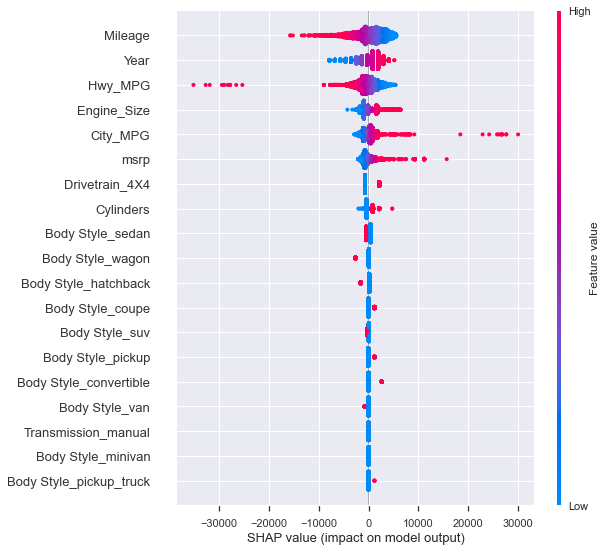

In [26]:
#Get SHAP values from a basic regression
model = LinearRegression()
model.fit(X_train, y_train)

explainer = shap.Explainer(model.predict, X_train)
shap_test = explainer(X_test)

shap.summary_plot(shap_test)

In [27]:
#Get shap values for an EN regression
alphas = np.arange(-50,50,.01) #I tried larger ranges before narrowing 
l1_rats = np.arange(0,1.01,.01)

model = ElasticNetCV(alphas=alphas, l1_ratio=l1_rats, cv=5)
model.fit(X_tr, y_train)
alpha_encv = model.alpha_
l1_ratio_encv = model.l1_ratio_
score_encv = model.score(X_te, y_test)

Permutation explainer: 5040it [01:23, 52.36it/s]                                


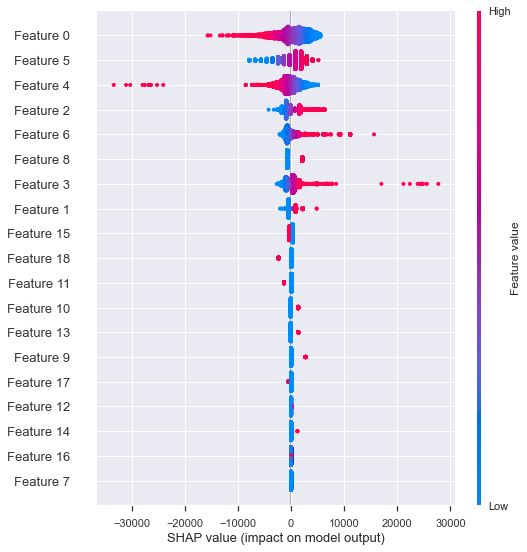

In [28]:
explainer = shap.Explainer(model.predict, X_tr)
shap_test = explainer(X_te)

shap.summary_plot(shap_test)

Text(0.5, 0, 'Prediction')

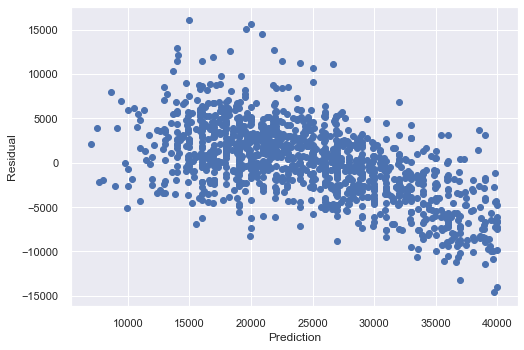

In [29]:
fig = plt.scatter(y_train, model.predict(X_tr)-np.array([row[0] for row in y_train.values]))
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
#There is a pattern, maybe some feature engineering?

In [30]:
print(f'Best alpha:{alpha_encv} Best L1 ratio: {l1_ratio_encv}, R^2 score: {score_encv}')

Best alpha:8.529999999988355 Best L1 ratio: 1.0, R^2 score: 0.6316944664546809


### Visualize Alphas

Best Alpha: 9.000000000000838


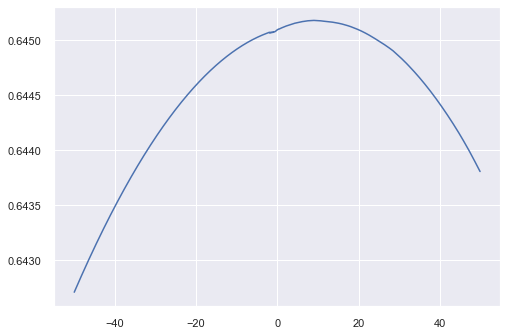

In [31]:
lasso_grid = build_grid_search_est(Lasso(), X_tr, y_train, cv=5,
                                       alpha=np.arange(-50,50,.1))

Best Alpha: 9.019999999999595


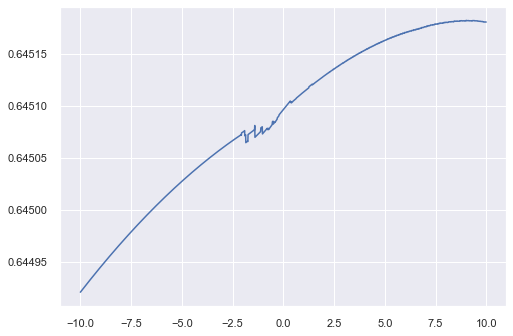

In [32]:
test = build_grid_search_est(Lasso(), X_tr, y_train, cv=5,
                                       alpha=np.arange(-10,10,.01))

Best Alpha: 1.0


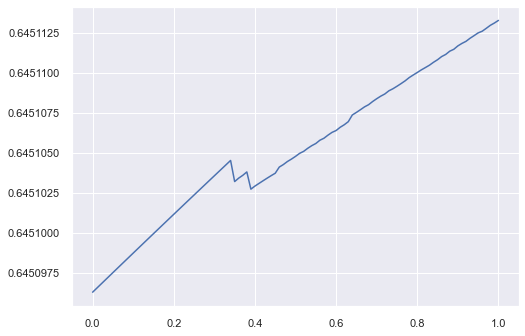

In [33]:
en_grid = build_grid_search_est(Lasso(), X_tr, y_train, cv=5,
                                alpha=np.arange(0,1.01,.01))

Best Alpha: 3.3000000000007574


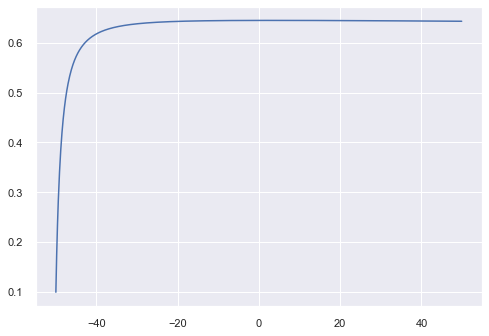

In [34]:
ridge_grid = build_grid_search_est(Ridge(), X_tr, y_train, cv=5,alpha=np.arange(-50,50,.1))

In [50]:
ridge_grid.l1_ratio_

AttributeError: 'GridSearchCV' object has no attribute 'l1_ratio_'

Metrics

In [35]:
y_pred = lasso_grid.predict(X_te)
print("Lasso Regression:", mean_squared_error(y_test, y_pred))

y_pred = ridge_grid.predict(X_te)
print("Ridge Regression:", mean_squared_error(y_test, y_pred))

y_pred = en_grid.predict(X_te)
print("ElasticNet Regression:", mean_squared_error(y_test, y_pred))

Lasso Regression: 18619372.21991275
Ridge Regression: 18630563.929146875
ElasticNet Regression: 18642253.469781276


Text(0.5, 1.0, 'Lasso Regression Model at Optimal Lambda')

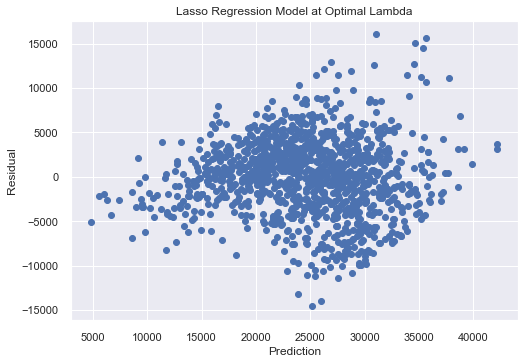

In [36]:
y_pred = lasso_grid.predict(X_tr)
fig = plt.scatter(y_pred, y_pred-np.array([row[0] for row in y_train.values]))
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
fig.axes.set_title('Lasso Regression Model at Optimal Lambda')

Text(0.5, 1.0, 'Lasso Regression Model at Optimal Lambda')

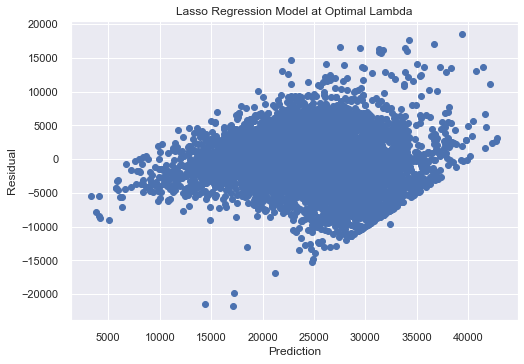

In [37]:
y_pred = lasso_grid.predict(X_te)
fig = plt.scatter(y_pred, y_pred-np.array([row[0] for row in y_test.values]))
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
fig.axes.set_title('Lasso Regression Model at Optimal Lambda')

Text(0.5, 1.0, 'Ridge Regression Model at Optimal Lambda')

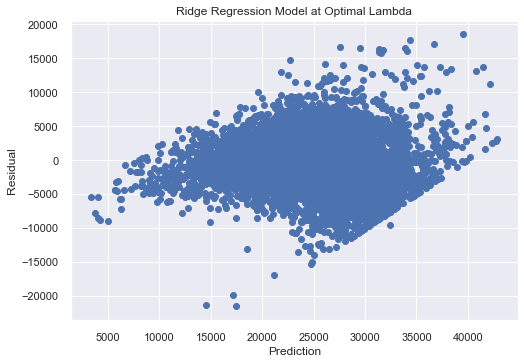

In [38]:
y_pred = ridge_grid.predict(X_te)
fig = plt.scatter(y_pred, y_pred-y_test.values)
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
fig.axes.set_title('Ridge Regression Model at Optimal Lambda')

Text(0.5, 1.0, 'Elastic Net Regression Model at Optimal Lambda')

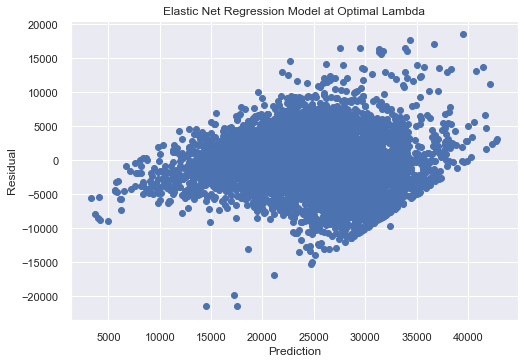

In [39]:
y_pred = en_grid.predict(X_te)
fig = plt.scatter(y_pred, y_pred-np.array([row[0] for row in y_test.values]))
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
fig.axes.set_title('Elastic Net Regression Model at Optimal Lambda')

In [47]:
X_tr.shape

(1259, 19)

In [45]:
y_train.values.shape

(1259, 1)

#### Deal with Heteroskedasticity by removing outliers

ValueError: x and y must be the same size

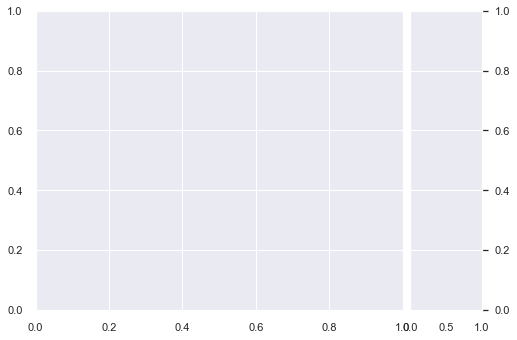

In [42]:
#Visualize Residuals
# Instantiate and fit the visualizer
model = Lasso(alpha=-2.1999999999993207)
visualizer_residuals = ResidualsPlot(model)  #arg hist=False skips the hist
visualizer_residuals.fit(X_tr, y_train.values)
visualizer_residuals.score(X_te, y_test.values)
visualizer_residuals.show()

In [2]:
#Handle Residuals
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X_tr[i_less_influential], y_train[i_less_influential]

model = ElasticNet(alpha=alpha_encv, l1_ratio=l1_ratio_encv)
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.score(X_te, y_test)
visualizer_residuals.show()

NameError: name 'visualizer' is not defined

In [ ]:
# Heteroskedasticity

### Plots

In [ ]:
shap.plots.bar(shap_test, max_display=9)

In [ ]:
raise ValueError

In [ ]:
shap.summary_plot(shap_test)

In [ ]:
figsize = (13,8)
xlim = [0, 41]
font={'size': 20}
sns.set(style='whitegrid', font_scale=2.5)
act_label = 'actual price [k$]'
pred_label='predicted price [k$]'
plot_act_vs_pred(y_test, model_en.predict(X_te_new), scale=1000, act_label=act_label, pred_label=pred_label, 
                 figsize=figsize, xlim=xlim, ylim=xlim, font=font)

Get dummies

In [ ]:


alphas = np.arange(-5,10,.5)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr.columns)
plt.show()

In [ ]:
#df with all dummy variables except make
all_dumms = pd.get_dummies(df.iloc[:,:-2])
all_dumms.columns = all_dumms.columns.map(lambda x: x.replace('Drivetrain_','').replace('Fuel Type_','').replace('Body_Style_','').replace('Doors_2','2_Door'))

#df with dummies(except make)
some_dumms = pd.get_dummies(df.iloc[:,:-2])

#df with no dummies
no_dumms = df.drop(columns=['Transmission','Drivetrain','Fuel Type','Body Style','Doors'])


In [ ]:
cdf = pd.DataFrame(regression.coef_, X.columns, columns=['Coefficients'])
sorted_feature_importance = regressor.feature_importances_.argsort()
plt.barh(df.columns[sorted_feature_importance], 
        regressor.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


## Functions